**Generative Adversarial Network using MNIST**

In this code, we are going to implement step-by-step a Generative Adversarial Network (GAN) on the MNIST dataset. If you have any questions, you can contact the instructor. The code needs GPU to run at an acceptable rate: if you are in Colab, go to Menu > Runtime > Change runtime type and select GPU as Hardware accelerator. If you are running this code locally, make sure you have a GPU and the necessary libraries installed.

The first thing we need to do is to import the necessary libraries. We will use numpy, matplotlib, torch, tqdm and torchvision to load the dataset. We will also use the magic command `%matplotlib inline` to show the plots in the notebook. Note that we also seed the code for reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.datasets as datasets
%matplotlib inline

# Seed the code for reproducibility
rng = np.random.default_rng(1234)
_ = torch.manual_seed(1234)

Now, we are going to define the GAN. We will use a simple architecture, with 3 fully connected layers for both the generator and the discriminator. We will use ReLU as activation function for the generator, and Sigmoid as activation function for the discriminator. We will use the Binary Cross Entropy (BCE) loss function, and the Adam optimizer. We will also define a method to train the GAN. Note that we will use the GPU if available.

In [2]:
class GAN(nn.Module):
    def __init__(self, noise_dim=100, hidden_dim=128):
        super().__init__()
        self.noise_dim = noise_dim
        self.hidden_dim = hidden_dim
        self.generator = nn.Sequential(
            nn.Linear(self.noise_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 784),
            nn.Tanh(),
        )
        self.discriminator = nn.Sequential(
            nn.Linear(784, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1),
            nn.Sigmoid(),
        )

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available():
            print('Using GPU: ' + torch.cuda.get_device_name(0))
            self.cuda()
        else:
            print('Using CPU: note that the code may be slow')

    def forward(self, x):
        return self.generator(x)

    def fit(self, X_train, X_val, epochs=50, batch_size=2048, show_every=5, train_disc=5):  # Method to train the GAN

        self.optimizer_g = torch.optim.Adam(self.generator.parameters(), lr=0.001)  # Optimizer for the generator
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=0.001)  # Optimizer for the discriminator
        self.criterion = nn.BCELoss()  # Loss function

        train_losses_g = []  # List to store the training loss of the generator
        train_losses_d = []  # List to store the training loss of the discriminator
        val_losses_g = []  # List to store the validation loss of the generator
        val_losses_d = []  # List to store the validation loss of the discriminator
        acc_real = []  # List to store the accuracy of the discriminator on real images (validation)
        acc_fake = []  # List to store the accuracy of the discriminator on fake images (validation)

        self.generator.to(self.device)
        self.discriminator.to(self.device)
        X_train = X_train.to(self.device)
        X_val = X_val.to(self.device)

        gen_images = []  # To store generated images for plotting later

        for epoch in tqdm(range(epochs)):  # Loop over the epochs
            losses_g = []
            losses_d = []
            for i in range(0, X_train.shape[0], batch_size):  # Loop over the batches
                x = X_train[i:i + batch_size] # Get the batch

                for _ in range(train_disc):
                    # First, train the discriminator
                    noise = torch.randn(batch_size, self.noise_dim).to(self.device)  # Generate noise
                    fake_images = self.generator(noise)  # Generate fake images
                    real_images = x  # Get real images
                    combined_images = torch.cat([fake_images, real_images])  # Combine fake and real images
                    labels = torch.cat([torch.zeros((batch_size, 1)), torch.ones((x.shape[0], 1))]).to(self.device)  # Labels for the discriminator: 0 for fake images, 1 for real images
                    predictions = self.discriminator(combined_images)  # Get the predictions of the discriminator
                    loss_d = self.criterion(predictions, labels)  # Compute the loss
                    self.optimizer_d.zero_grad()  # Reset the gradients
                    loss_d.backward()  # Backpropagate
                    self.optimizer_d.step()  # Update the weights
                    losses_d.append(loss_d.item())  # Store the loss

                # Second, train the generator
                noise = torch.randn(batch_size, self.noise_dim).to(self.device)  # Generate noise
                fake_images = self.generator(noise)  # Generate fake images
                labels = torch.ones((batch_size, 1)).to(self.device)  # Labels for the generator: 1 for fake images
                predictions = self.discriminator(fake_images)  # Get the predictions of the discriminator
                loss_g = self.criterion(predictions, labels)  # Compute the loss
                self.optimizer_g.zero_grad()  # Reset the gradients
                loss_g.backward()  # Backpropagate
                self.optimizer_g.step()  # Update the weights
                losses_g.append(loss_g.item())  # Store the loss

            train_losses_g.append(np.mean(losses_g))  # Compute the average training loss of the generator
            train_losses_d.append(np.mean(losses_d))  # Compute the average training loss of the discriminator

            # Compute the validation loss
            with torch.no_grad():
                noise = torch.randn(X_val.shape[0], self.noise_dim).to(self.device)  # Generate noise
                fake_images = self.generator(noise)  # Generate fake images
                real_images = X_val  # Get real images
                combined_images = torch.cat([fake_images, real_images])  # Combine fake and real images
                labels = torch.cat([torch.zeros((X_val.shape[0], 1)), torch.ones((X_val.shape[0], 1))]).to(self.device)  # Labels for the discriminator: 0 for fake images, 1 for real images
                predictions = self.discriminator(combined_images)  # Get the predictions of the discriminator
                loss_d = self.criterion(predictions, labels)  # Compute the loss
                val_losses_d.append(loss_d.item())  # Store the loss

                acc_real.append(torch.mean((predictions[batch_size: ] > 0.5).float()).item())  # Store the accuracy on real images
                acc_fake.append(torch.mean((predictions[0: batch_size] > 0.5).float()).item())  # Store the accuracy on fake images

                noise = torch.randn(X_val.shape[0], self.noise_dim).to(self.device)  # Generate noise
                fake_images = self.generator(noise)  # Generate fake images
                labels = torch.ones((X_val.shape[0], 1)).to(self.device)  # Labels for the generator: 1 for fake images
                predictions = self.discriminator(fake_images)  # Get the predictions of the discriminator
                loss_g = self.criterion(predictions, labels)  # Compute the loss
                val_losses_g.append(loss_g.item())  # Store the loss

                if epoch % show_every == 0:  # Save 16 generated images
                    gen_images.append((epoch + 1, fake_images[:16, ].cpu().detach().numpy()))
        gen_images.append((epoch + 1, fake_images[:16, ].cpu().detach().numpy()))  # Add the final images generated
        return train_losses_g, train_losses_d, val_losses_g, val_losses_d, acc_real, acc_fake, gen_images

Now, we are going to load the MNIST dataset. We will use the `datasets` module from `torchvision` to load the dataset. We will also convert the images to vectors, and normalize the images to be in the $[0, 1]$ range.

In [3]:
# Load MNIST data
mnist_tr_set = datasets.MNIST(root='./D_set', train=True, download=True, transform=None)  # Training set
mnist_ts_set = datasets.MNIST(root='./D_set', train=False, download=True, transform=None)  # Test set
train_data = torch.reshape(mnist_tr_set.data, (mnist_tr_set.data.shape[0], 784)).float() / 255  # Convert images to be in [0, 1] range
test_data = torch.reshape(mnist_ts_set.data, (mnist_ts_set.data.shape[0], 784)).float() / 255  # Convert images to be in [0, 1] range

We are ready to train the GAN. We will use 10 dimensions for the latent representation, and we will train the GAN for 100 epochs. We will use a batch size of 2048. Beware of using the GPU: otherwise, the code may take too long to run (on a Tesla T4, it runs in less than 1 minute).

In [4]:
dimension = 10  # Latent dimension to be used
print('Training GAN...')
model = GAN(noise_dim=dimension)
train_losses_g, train_losses_d, val_losses_g, val_losses_d, acc_real, acc_fake, gen_images = model.fit(train_data, test_data, epochs=100, batch_size=2048, show_every=20)

Training GAN...
Using GPU: Tesla T4


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


Now, we will show the convergence curves of the GAN, as well as the accuracies evolution during test. Note that the discriminator becomes confused about real images, and is unable to detect fake images, which means that the generator is fooling the discriminator.

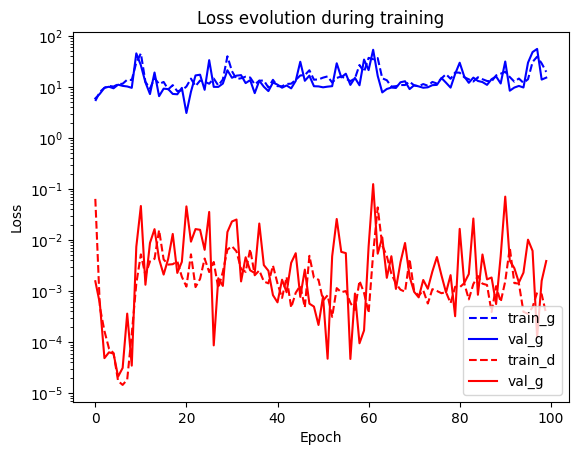

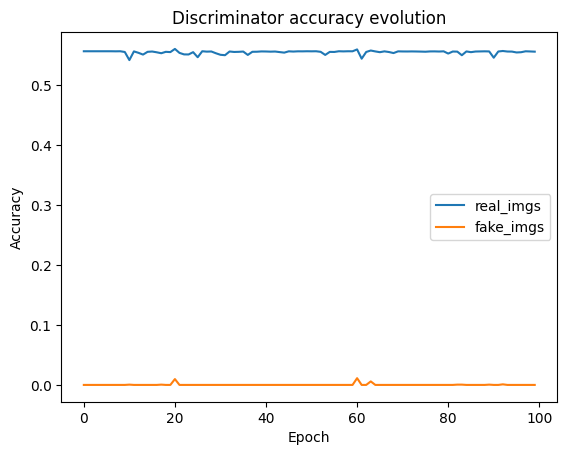

In [5]:
plt.semilogy(train_losses_g, label='train_g', color='b', linestyle='dashed')
plt.semilogy(val_losses_g, label='val_g', color='b')
plt.semilogy(train_losses_d, label='train_d', color='r', linestyle='dashed')
plt.semilogy(val_losses_d, label='val_g', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss evolution during training')
plt.legend(loc='best')
plt.show()

plt.plot(acc_real, label='real_imgs')
plt.plot(acc_fake, label='fake_imgs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator accuracy evolution')
plt.legend(loc='best')
plt.show()

Now, we will show the generated images during training, in order to see how the GAN has passed from producing noise, to producing images that resemble numbers. Of course, a longer training would mean that images of higher quality are produced (as well as many tricks that could be used to improve the stability of the GAN training).

Generated images, epoch 1


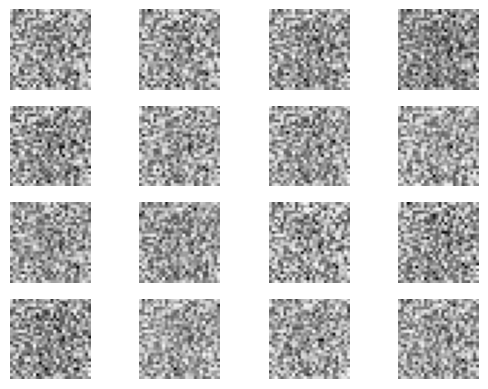

Generated images, epoch 21


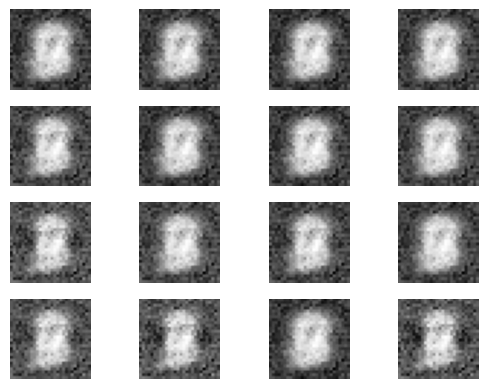

Generated images, epoch 41


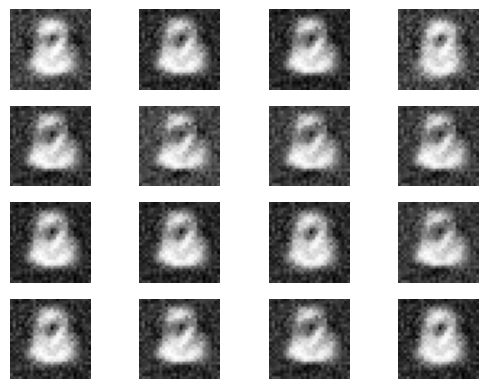

Generated images, epoch 61


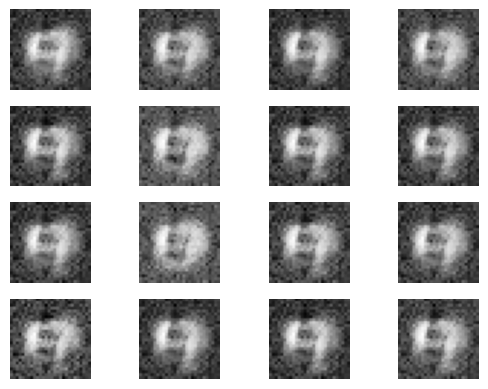

Generated images, epoch 81


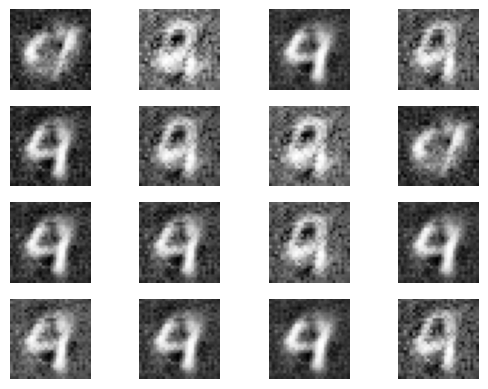

Generated images, epoch 100


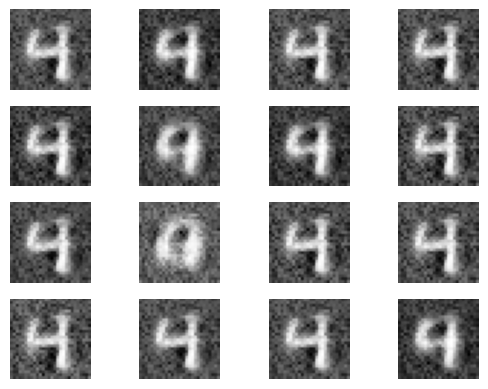

In [6]:
for epoch, imgs in gen_images:
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(imgs[i].reshape([28, 28]), cmap='Greys_r')
        plt.axis('off')
    print('Generated images, epoch ' + str(epoch))
    plt.show()
